# DS 542 - 2025 Fall - Homework 3

Solve the following problems using PyTorch and then submit in [Gradescope](https://www.gradescope.com/courses/1071076).


Do not use any PyTorch module classes for any of the problems.



Tensors and functions such as `tensor.log` and automatic gradient tracking are allowed.

## Problem 1 - Compute Roots of a Function

The roots of a function are inputs that make that function zero.
Use gradient descent to solve for both roots of $f(x) = x^2 - 4x + 1$.

Save the two roots in a variable `roots` and print it.

Hint: The discussion on 9/17 will focus on similar problems.

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import math

In [31]:
def f(x):
  return x**2 - 4*x + 1

In [32]:
a = torch.tensor(0.0, requires_grad=True)
b = torch.tensor(3.0, requires_grad=True)
lr = 0.05
steps = 2000
loss_hist, a_hist, b_hist = [], [], []

for t in range(steps):
    loss = f(a)**2 + f(b)**2
    loss_hist.append(loss.item())
    a_hist.append(a.item())
    b_hist.append(b.item())

    loss.backward()

    with torch.no_grad():
        a -= lr * a.grad
        b -= lr * b.grad

        a.grad.zero_()
        b.grad.zero_()

roots = [a.item(), b.item()]

In [33]:
# YOUR CHANGES HERE
roots

[0.2679491937160492, 3.732050895690918]

## Problem 2 - Implement Logistic Regression

Implement logistic regression in PyTorch to predict the outcome column of the Pima Indians Diabetes data set.

In [34]:
import numpy as np
import pandas as pd

In [35]:
df = pd.read_csv("https://github.com/npradaschnor/Pima-Indians-Diabetes-Dataset/raw/refs/heads/master/diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [36]:
input_df = df.drop(columns=["Outcome"])
target = df["Outcome"]

### Part A - Setup the Logistic Regression and Prediction Function

In [37]:
# YOUR CHANGES HERE
n_features = 8
weights = torch.randn(n_features, requires_grad=True) # tensor of 8 random weights, 1 for each feature
# requires_grad - tracks gradients for this tensor so we can update during training
bias = torch.zeros(1, requires_grad=True) # creates a single bias term initialized to 0

def predict(X, weights, bias):

    z = torch.matmul(X, weights) + bias # computes linear combination

    predictions = torch.sigmoid(z) # applies sigmoid function to convert z values to probs between 0-1

    return predictions

### Part B - Write a Function Calculating the Loss for this Logistic Regression

In [38]:
# Loss function
def compute_loss(y_true, y_pred):
    eps = 1e-15  # extremely small number to prevent log(0)
    m = y_true.shape[0] # number of samples
    loss = -(1/m) * torch.sum( # negative average because MINIMIZING LOSS
        y_true * torch.log(y_pred + eps) +
        (1 - y_true) * torch.log(1 - y_pred + eps)
    )
    return loss
    # when y = 1, only first term matters
    # when y = 0, only second term matters

### Part C - Optimize the Logistic Regression Parameters using Gradient Descent


In [39]:
lr = 0.01
steps = 3000
loss_hist = [] # stores loss values for plotting
input_df_tensor = torch.tensor(input_df.values, dtype=torch.float32) # convert data to tensors
target_tensor = torch.tensor(target.values, dtype=torch.float32) # convert data to tensors

for t in range(steps): # loops through training steps
    predictions = predict(input_df_tensor, weights, bias)  # Run input through our model to get predicted probabilities
    loss = compute_loss(target_tensor, predictions) # Calculate how wrong our predictions are using binary cross-entropy

    loss.backward() # automatically computes gradients of loss w.r.t. weights and bias using backprob

    with torch.no_grad(): # temporarily disable gradient tracking
        weights -= lr * weights.grad # move weights in opposite direction of gradient
        bias -= lr * bias.grad # move bias in opposite direction of gradient

    weights.grad.zero_() # zero out gradients b/c PyTorch accumulates gradients
    bias.grad.zero_()

    if t % 10 == 0: # printing every 10 steps
        loss_hist.append(loss.item())

### Part D - Plot Ground Truth vs Predicted Probabilities

Make a scatter plot where your logistic regression's predictions for each row of the data set are the x-axis, and the actual outcome is the y axis.

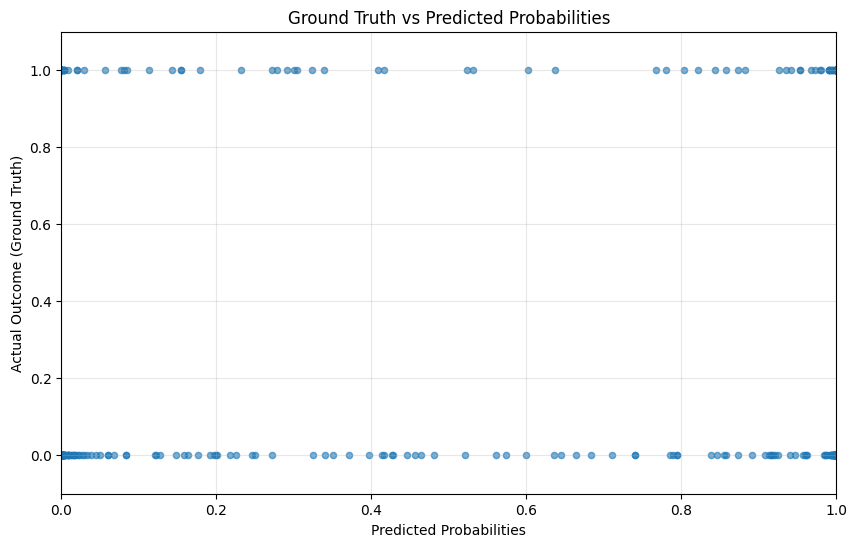

In [40]:
with torch.no_grad():  # Don't need gradients for evaluation
    final_predictions = predict(input_df_tensor, weights, bias)

pred_probs = final_predictions.numpy() # Convert to numpy for plotting
actual_outcomes = target_tensor.numpy()

plt.figure(figsize=(10, 6))
plt.scatter(pred_probs, actual_outcomes, alpha=0.6, s=20)
plt.xlabel('Predicted Probabilities')
plt.ylabel('Actual Outcome (Ground Truth)')
plt.title('Ground Truth vs Predicted Probabilities')
plt.grid(True, alpha=0.3)

plt.xlim(0, 1)
plt.ylim(-0.1, 1.1)

plt.show()

## Problem 3 - Implement a Shallow Neural Network

Implement a neural network with one hidden layer to predict the outcome column of the Pima Indians Diabetes data set.

### Part A - Setup the Neural Network and Prediction Function





In [41]:
import torch
import torch.nn.functional as F

input_size = 8
hidden_size = 10    # number of neurons in hidden layer
output_size = 1     # single output (binary classification)

# Initialize weights and biases
W1 = torch.randn(input_size, hidden_size, requires_grad=True)  # input to hidden layer, weight matrix from input(8) to hidden(10), shape 8,10
b1 = torch.zeros(hidden_size, requires_grad=True)  # hidden layer bias, bias vector for hidden layer, shape (10,)
W2 = torch.randn(hidden_size, output_size, requires_grad=True) # hidden layer to output, weight matrix from hidden(10) to output(1), shape (10,1)
b2 = torch.zeros(output_size, requires_grad=True)  # Output bias, bias for output layer, shape (1,)
# all initialized randomly except biases, which are set to zero

def predict_nn(X, W1, b1, W2, b2):
    # Forward pass
    z1 = torch.matmul(X, W1) + b1    # Linear transformation to hidden layer
    a1 = torch.relu(z1)              # ReLU activation function- sets neg values to 0, keeps positive values. allows it to learn non-linear decision boundaries
    z2 = torch.matmul(a1, W2) + b2   # Linear transformation to output-
    predictions = torch.sigmoid(z2)  # final sigmoid for binary classification

    return predictions

### Part B - Write a Function Calculating the Loss for the Neural Network

In [42]:
def compute_nn_loss(y_true, y_pred):
    eps = 1e-15  # Small value to prevent log(0)
    m = y_true.shape[0]

    y_pred = y_pred.squeeze()  # Remove extra dimensions if needed

    loss = -(1/m) * torch.sum( # same binary cross-entropy as logreg
        y_true * torch.log(y_pred + eps) +
        (1 - y_true) * torch.log(1 - y_pred + eps)
    )
    return loss

### Part C - Optimize the Neural Network with Gradient Descent

In [43]:
# Convert data to tensors (same as before)
input_df_tensor = torch.tensor(input_df.values, dtype=torch.float32)
target_tensor = torch.tensor(target.values, dtype=torch.float32)

# Training parameters
lr = 0.01
steps = 5000  # More steps for neural network
loss_hist = []
# training loop extremely similar to logreg, but 4 parameters instead of 2

for t in range(steps):
    # Forward pass
    predictions = predict_nn(input_df_tensor, W1, b1, W2, b2)

    # Compute loss
    loss = compute_nn_loss(target_tensor, predictions)

    # Backward pass
    loss.backward()

    # Update parameters
    with torch.no_grad():
        W1 -= lr * W1.grad
        b1 -= lr * b1.grad
        W2 -= lr * W2.grad
        b2 -= lr * b2.grad

    # Zero gradients
    W1.grad.zero_()
    b1.grad.zero_()
    W2.grad.zero_()
    b2.grad.zero_()

    # Track loss history
    if t % 100 == 0:
        loss_hist.append(loss.item())
        print(f"Step {t}, Loss: {loss.item():.4f}")

Step 0, Loss: 21.0106
Step 100, Loss: 14.7846
Step 200, Loss: 10.9499
Step 300, Loss: 18.4310
Step 400, Loss: 10.8770
Step 500, Loss: 9.1053
Step 600, Loss: 16.6161
Step 700, Loss: 15.2895
Step 800, Loss: 8.6999
Step 900, Loss: 8.5963
Step 1000, Loss: 8.2195
Step 1100, Loss: 13.8247
Step 1200, Loss: 6.1295
Step 1300, Loss: 1.0423
Step 1400, Loss: 0.7179
Step 1500, Loss: 0.6518
Step 1600, Loss: 0.6439
Step 1700, Loss: 0.6385
Step 1800, Loss: 0.6303
Step 1900, Loss: 0.6233
Step 2000, Loss: 0.6173
Step 2100, Loss: 0.6124
Step 2200, Loss: 0.6100
Step 2300, Loss: 0.6079
Step 2400, Loss: 0.6079
Step 2500, Loss: 0.6046
Step 2600, Loss: 0.6012
Step 2700, Loss: 0.5999
Step 2800, Loss: 0.5975
Step 2900, Loss: 0.6003
Step 3000, Loss: 0.5958
Step 3100, Loss: 0.5944
Step 3200, Loss: 0.5930
Step 3300, Loss: 0.5910
Step 3400, Loss: 0.5900
Step 3500, Loss: 0.5893
Step 3600, Loss: 0.5876
Step 3700, Loss: 0.5868
Step 3800, Loss: 0.5859
Step 3900, Loss: 0.5851
Step 4000, Loss: 0.5836
Step 4100, Loss: 0.5

### Part D - Plot Ground Truth vs Predicted Probabilities

Make a scatter plot where your neural network's predictions for each row of the data set are the x-axis, and the actual outcome is the y axis.

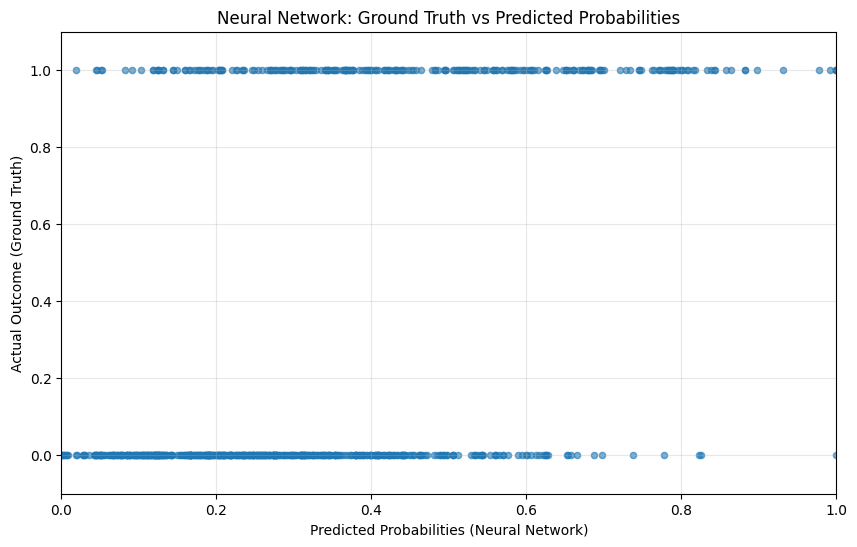

In [44]:
# Get final predictions after training
with torch.no_grad():
    final_predictions_nn = predict_nn(input_df_tensor, W1, b1, W2, b2)

# Convert to numpy for plotting
pred_probs_nn = final_predictions_nn.squeeze().numpy()
actual_outcomes = target_tensor.numpy()

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(pred_probs_nn, actual_outcomes, alpha=0.6, s=20)
plt.xlabel('Predicted Probabilities (Neural Network)')
plt.ylabel('Actual Outcome (Ground Truth)')
plt.title('Neural Network: Ground Truth vs Predicted Probabilities')
plt.grid(True, alpha=0.3)

# Set axis limits
plt.xlim(0, 1)
plt.ylim(-0.1, 1.1)

plt.show()